![title](img/logo.png)
# Biometrics System Concepts
## Assignment 1: Evaluating performance of biometric systems
<b>Name</b>: Charalampos Kalavrytinos |
<b>Student-nr</b>: r0833114|
<b>Date</b>: March 9, 2021
---

In this assignment we focus on evaluating the performance of any biometric system in a verification and identification setting. 

Before you get started you should be able to properly distinguish verification from identification and know the corresponding validation procedures. If this is not the case for you yet, **review the lecture notes!** We will give a short recap to refresh your memory: 
* **VERIFICATION** (a.k.a. authentication): Authenticating a claimed identity (is this person who he/she claims to be?).

* **IDENTIFICATION**: Associate a particular individual with an identity (who is this unidentified individual?).

This document is structured as follows:

- [I. Reading the data](#I.-Reading-the-data)
- [II. Validation of verification system](#II.-Validation-of-verification-system)
- [III. Validation of identification system](#III.-Validation-of-identification-system)
- [IV. Assignment Instructions](#IV.-Assignment-Instructions)


Code examples will be provided below. You can and are invited to adapt these at your will (different parameter settings, different choices of alogorithmic components). The code examples in this assignment is just sekeleton code,  **adapt where needed! And try to keep things structured!** 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import xml.etree.ElementTree as ET  # package for reading xml files
import os
import pandas as pd                 # package for data analysis with fast and flexible data structures
from tqdm.notebook import tqdm as tqdm_notebook
import src.BSSR1 as BSSR1           # import local modules for reading and converting BSSR1 fingerprint score data

<div class="alert alert-block alert-info">
<b>Tip:</b> 
Many operations have already been implemented in <a href="https://docs.scipy.org/doc/numpy/index.html">SciPy</a>, feel free to use them or any other unless explicitely stated not to in the assignment.</div>

## I. Reading the data
In this assignment we focus on the validation of a pre-exising biometric system. We will make use of actual predicted fingerprint similarity scores, from the left and right index fingers. This bypasses all steps of preprocessing, feature extraction and matching and allows us to concentrate on the score evaluation procedures. The scores are the result of comparing an enrolled user's image with the score of the same (genuine scores) or another user (impostor scores). The data (biometrics scores set BSSR1) are made available through the American National Institute of Standards and Technologies [(NIST)](https://www.nist.gov/itl/iad/image-group/nist-biometric-scores-set-bssr1). They are provided as part of your assignment folder in the `data/fing-x-fing` subfolder. 

In this code example we will compare the performance of a biometric system that was based on the right index finger to a biometric system based on the left index finger. These systems are referred to as `ri` and `li` respectively in both code and text.  

### 1.1. Constructing the similarity matrix and reading the genuine and impostor scores
We provide you here with the code to read the scores from the files (normally you can leave this code as-is).

The code consits of 3 steps that are executed for both the `ri` and `li` system: 
1. Converted the scores to a similarity matrix with the genuine scores on the diagonal and the impostor scores on the off-diagonal elements. 
2. Subsample individuals (not needed but reduces calculation times). 
3. Convert the original (subsampled) scores to a linear list of scores with associated labels of genuine or impostor (simplifies use of [scikit-learn](https://scikit-learn.org/stable/index.html))

<div class="alert alert-block alert-info">
<b>Tip:</b> 
For more information about the structure of the data, have a look at the <a href="./data/fing_x_fing/README.html">readme</a>.
</div>


In [2]:
# set paths to files containing identity tags of enrollees and users
li_enrollees_id_filepath = './data/fing_x_fing/sets/dos/li/enrollees.xml'
li_users_id_filepath = './data/fing_x_fing/sets/dos/li/users.xml'

ri_enrollees_id_filepath = './data/fing_x_fing/sets/dos/ri/enrollees.xml'
ri_users_id_filepath = './data/fing_x_fing/sets/dos/ri/users.xml'

# set list string for scores files
li_scores_list_str = './data/fing_x_fing/sims/dos/li/V/*.bin'
ri_scores_list_str = './data/fing_x_fing/sims/dos/ri/V/*.bin'

In [3]:
# STEP 1: read BSSR1 scores for left index and take 1000 as a similarity matrix
(li_fingxfing_df, li_enrollees, li_users, li_column_names) = BSSR1.read_BSSR1_scores_from_file(li_enrollees_id_filepath, li_users_id_filepath, li_scores_list_str)
# STEP 2: subsample the scores
li_sim = BSSR1.df2sim_subsample(li_fingxfing_df, column_names = li_column_names, nr_individuals = 1000)
# STEP 3: convert to genuine and impostor scores, the *_genuine_id provides a mask for the genuine scores
li_genuine_id, li_scores = BSSR1.sim2scores(li_sim)
# STEP 4: delete large df from memory for better memory management
del li_fingxfing_df

KeyboardInterrupt: 

In [4]:
# STEP 1: read BSSR1 scores for left index and take 1000 as a similarity matrix
(ri_fingxfing_df, ri_enrollees, ri_users, ri_column_names) = BSSR1.read_BSSR1_scores_from_file(ri_enrollees_id_filepath, ri_users_id_filepath, ri_scores_list_str)
# STEP 2: subsample the scores
ri_sim = BSSR1.df2sim_subsample(ri_fingxfing_df, column_names = ri_column_names, nr_individuals = 1000)
# STEP 3: convert to genuine and impostor scores, the *_genuine_id provides a mask for the genuine scores
ri_genuine_id, ri_scores = BSSR1.sim2scores(ri_sim)
# STEP 4: delete large df from memory for better memory management
del ri_fingxfing_df

In [5]:
num_subjects = 1000
li_subject_ids = li_sim.columns.tolist()
ri_subject_ids = ri_sim.columns.tolist()
ri_genuine_id
#print(li_subject_ids, ri_subject_ids)

array([1., 1., 1., ..., 0., 0., 0.])

<div class="alert alert-block alert-info">
<b>Tip:</b> 
In this assignment we focus only on evaluating biometric systems. It is in your best interest to write your code such that it can easily be reused in the upcoming assignments, where you will have to develop entire biometric system pipelines.</div>

## II. Validation of verification system

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)

The performance of a valitation/authentication scenario can be expressed in a number of ways (see [Jain et al.][1] section 1.4.1.1 for more information). In essence one has a binary classification problem: is it the claimed identity or not? 

We denote our classes as:
<ol start="0">
  <li>Impostor (False),</li>
  <li>Genuine (True).</li>
</ol>

Furthermore, we represent the set of scores as s, the imposter event as $I$ and a genuine event as $G$.

### 1. Evaluation using FMR, FRR, ROC and Precision/Recall curves

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)



#### 1.1 Genuine and impostor score distributions
Given the genuine and impostor scores (from section I), we can plot the imposter $p(s | I)$ and genuine $p(s | G)$ distribution to gain some first insights in the system. The result should look something like this:

<p align="center">
    <img src="img/ScoreDistributions.png" width="250" height="auto"/>
</p>


<div class="alert alert-block alert-success">
<b>Q1: </b> Score distributions
<ul>
  <li>Plot the genuine and impostor score distributions in a single plot.</li>
  <li>Do you need to normalize the distributions? Why (not)?</li>
  <li>Describe qualitatively this combined plot (hint: limit the score range for better understanding)</li>
</ul>  
</div>

(2000000,)


Text(0, 0.5, 'probabilty')

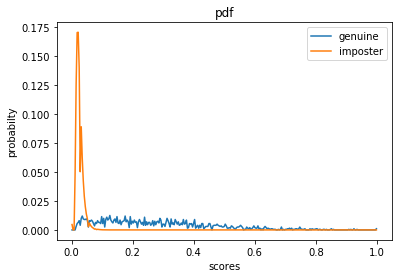

In [36]:
"""Plot the genuine and imposter score distributions."""
from scipy import stats
max_val = 1                 # max threshold
min_val = 0                 # min threshold
nbins = 300                 # number of bins for getting distribution
bins = np.linspace(min_val, max_val, nbins)

y_true = np.append(ri_genuine_id,li_genuine_id)         # actual labels from dataset

g_scores = np.append(ri_scores[ri_genuine_id.astype(bool)],li_scores[li_genuine_id.astype(bool)])       # genuine scores
i_scores = np.append(ri_scores[~ri_genuine_id.astype(bool)],li_scores[~li_genuine_id.astype(bool)])     # imposter scores
combined_scores = np.concatenate((ri_scores,li_scores), axis=0)                             # cumulative scores
#print(combined_scores.shape)

hist1, bins = np.histogram(g_scores, bins=bins, density=True)
bin_centers = 0.5*(bins[1:] + bins[:-1])        # for x axis plot

#print(hist1.sum())
g_pdf = hist1/hist1.sum()                       # normalize to get probability distr

hist2, bins = np.histogram(i_scores, bins=bins, density=True)
i_pdf = hist2/hist2.sum()

#plt.figure(figsize=(6, 4))
plt.figure()
plt.plot(bin_centers, g_pdf, label="genuine")
plt.plot(bin_centers, i_pdf, label="imposter")
plt.legend()
plt.title('pdf')
plt.xlabel('scores')
plt.ylabel('probabilty')
plt.savefig('./figs/pdf_cum.png')

Text(0, 0.5, 'probabilty')

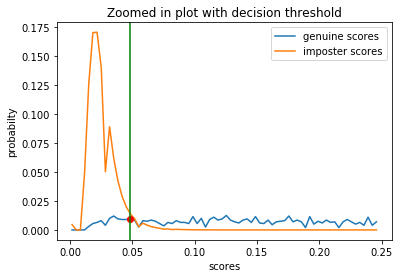

In [7]:
"""Find and plot (empirically) optimal decision threshold"""
plt.figure()
thres = np.argwhere(np.diff(np.sign(g_pdf[i_pdf>0] - i_pdf[i_pdf>0]))).flatten()          # find where the 2 distributions cross (pos values)
justapart = int(bin_centers.shape[0]/4)             # get the first 1/4 of the distribution
xaxis = bin_centers[0:justapart] 
plt.plot(xaxis, g_pdf[0:justapart], label="genuine scores")
plt.plot(xaxis, i_pdf[0:justapart], label="imposter scores")
plt.plot(xaxis[thres], g_pdf[thres], 'ro')
plt.axvline(x=xaxis[thres],c='g')
#print(thres, bin_centers[thres])
plt.legend()
plt.title('Zoomed in plot with decision threshold')
plt.xlabel('scores')
plt.ylabel('probabilty')
plt.savefig('./figs/pdf_cum_th.png')

#### 2. FMR, FRR and Receiver Operating Characteristic (ROC) curve

The 'false accept' and 'false reject' regions in the illustration above are quantified using the False Match/Acceptance Rates (FMR/FAR) and False Non-Match/Rejections Rates (FNMR/FRR). The FMR and FNMR can easily be computed given the previously calculated probability distributions and a threshold value $\eta$. Practically this boils down to a counting problem, having $\mathcal{I}$ the indicator function (return 1 if x is true, else 0) we can compute:
$$
FMR(\eta) = p(s \geq \eta | I) \approx \frac{1}{|I|} \sum_{s \in I} \mathcal{I}(s \geq \eta),
$$
$$
FRR(\eta) = p(s < \eta | G) \approx \frac{1}{|G|} \sum_{s \in G} \mathcal{I}(s < \eta).
$$

We can also compute the Genuine Acceptance Rate (GAR)/True Match Rate (TMR) as:
$$
GAR(\eta) = p(s \geq \eta | G) = 1 - FRR(\eta).
$$

Note that choosing a threshold is always a tradeof between FMR and FNMR. <br>
<img src="img/FAR_FRR.png" width="300" height="auto" align="center"/>

To observe the impact of the threshold value, one often plots a [Receiver Operating Characteristic (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve. Usually in these curves the GAR/TMR is plotted against the FMR for different decision threshold values $\eta$. For those familiar with binary classification systems outside of the biometrics literature; the GAR/TMR is often referred to as the True Positive Rate (TPR), sensitivity or recall and FMR is also known as the False Positive Rate (FPR) or the False Accept Rate (FAR). 

<img src="img/ROC.png" width="700" height="auto" align="center"/>

<div class="alert alert-block alert-success">
<b>Q2: </b> ROC Curves
<ul>
    <li>Calculate FPR, TPR from the matching scores.</li>
    <li>Plot FAR and FRR as a function of matching scores.</li>
    <li>Plot the ROC curve. Plot for linear and logarithmic scale if needed. What do you observe?</li>
    <li>Plot the Detection Error Trade-off (DET) curve. How does it compare to ROC?</li>
</ul>  
</div>


<div class="alert alert-block alert-info">
<b>Tip:</b> 
We highly recommend you use the <a href="https://scikit-learn.org/stable/index.html">scikit-learn</a> package, it contains standard and advanced routines for machine learning, including classificaton and validation algorithms.
</div>

In [8]:
"""Calculate FPR, TPR from the matching scores."""
from sklearn import metrics
# based on the previously computed threshold
labels1 = np.append(np.zeros(thres[0]+1,dtype=int),np.ones(g_pdf.shape[0]-thres[0]-1,dtype=int))
labels2 = np.append(np.ones(thres[0],dtype=int),np.zeros(g_pdf.shape[0]-thres[0],dtype=int))

fmr = round(i_pdf[labels1.astype(bool)].sum(),4)
fpr = fmr
frr = round(g_pdf[labels2.astype(bool)].sum(),4)
tpr = 1 - frr
print(fpr, tpr)
# print(labels, '\n', labels1, '\n', labels2)

0.0324 0.9235


Text(0, 0.5, 'probabilty')

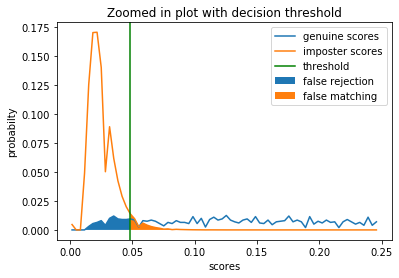

In [9]:
"""Plot FAR and FRR on the distributions."""
# FAR <=> FPR
# FRR <=> FNR <=> FN/P <=> 1-TPR
plt.figure()
part = ~(labels1[0:justapart].astype(bool))
g_pdf_part = g_pdf[0:justapart]
xaxis_part = xaxis[0:justapart]
plt.fill_between(xaxis_part[part], g_pdf_part[part], label='false rejection')

part = ~(labels2[0:justapart].astype(bool))
i_pdf_part = i_pdf[0:justapart]
plt.fill_between(xaxis_part[part], i_pdf_part[part], label='false matching')


plt.plot(xaxis, g_pdf[0:justapart], label="genuine scores")
plt.plot(xaxis, i_pdf[0:justapart], label="imposter scores")
#plt.plot(xaxis[thres], g_pdf[thres], 'ro')
plt.axvline(x=xaxis[thres],c='g', label="threshold")
#print(thres, bin_centers[thres])
plt.legend()
plt.title('Zoomed in plot with decision threshold')
plt.xlabel('scores')
plt.ylabel('probabilty')
plt.savefig('./figs/pdf_cum_th_areas.png')

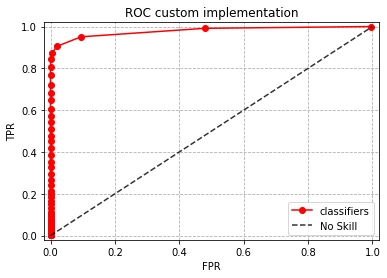

In [10]:
"""plot the ROC curve (TPR against the FPR for different threshold values)"""
from sklearn import metrics
plt.figure()
fpr_list = []
tpr_list = []
for threshold in range(1,nbins,5):
    labels1 = np.append(np.zeros(threshold+1,dtype=int),np.ones(g_pdf.shape[0]-threshold-1,dtype=int))
    labels2 = np.append(np.ones(threshold,dtype=int),np.zeros(g_pdf.shape[0]-threshold,dtype=int))

    fmr = round(i_pdf[labels1.astype(bool)].sum(),4)
    frr = round(g_pdf[labels2.astype(bool)].sum(),4)

    fpr_list.append(fmr)
    tpr_list.append(1-frr)

fig, ax = plt.subplots()
plt.plot(fpr_list, tpr_list,'ro-', label="classifiers")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC custom implementation')
ax.grid(linestyle='--')
identity_line = np.linspace(0, 1,50)
#plt.xscale('log')
#plt.yscale('log')
plt.plot(identity_line,identity_line, linestyle='dashed', color='black', alpha=0.8, label="No Skill")
plt.legend()
plt.ylim(-0.02, 1.02)
plt.xlim(-0.02, 1.02)
auc = np.abs(np.trapz(tpr_list,fpr_list, dx=1.0, axis=0))       # calculate auc geometrically as area
plt.savefig('./figs/roc_custom_cum.png')

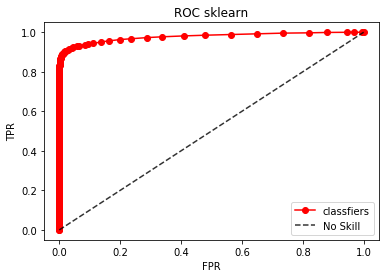

In [11]:
""" Using the built-in function of sklearn """
plt.figure()
fpr, tpr, th_roc = metrics.roc_curve(y_true, combined_scores)       # use built-in function of sklearn
auc2 = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,'ro-',label='classfiers')

plt.plot(identity_line,identity_line, linestyle='dashed', color='black', alpha=0.8, label="No Skill")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC sklearn')
plt.legend()
plt.savefig('./figs/roc_sklearn_cum.png')

Text(0.5, 1.0, 'Error rates depending on threshold')

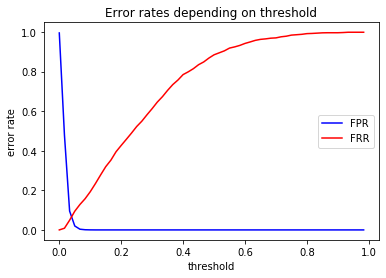

In [12]:
"""Plot FAR and FRR as a function of the decision threshold."""
plt.figure()
thr_axis = np.arange(0, 1, 1/len(tpr_list)).tolist()
plt.plot(thr_axis,fpr_list, 'b', label="FPR")
plt.plot(thr_axis,np.ones(len(tpr_list))-tpr_list,'r', label="FRR")
plt.xlabel('threshold')
plt.ylabel('error rate')
plt.legend()
plt.title('Error rates depending on threshold')
plt.savefig('./figs/error_rates_th_cum.png')

Text(0.5, 1.0, 'DET curve custom implementation')

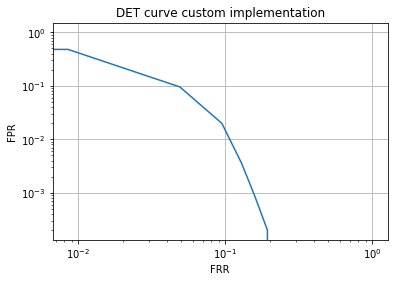

In [13]:
"""plot the DET curve (FRR (=1-tpr) against the FAR for different threshold values)"""
# FAR <=> FPR
# FRR <=> FNR <=> FN/P <=> 1-TPR
plt.figure()
fpr_list = []
frr_list = []
for threshold in range(1,nbins,5):          # each loop is a different threshold, step is 5 bins
    labels1 = np.append(np.zeros(threshold+1,dtype=int),np.ones(g_pdf.shape[0]-threshold-1,dtype=int))  # calculate the true labels
    labels2 = np.append(np.ones(threshold,dtype=int),np.zeros(g_pdf.shape[0]-threshold,dtype=int))

    fmr = round(i_pdf[labels1.astype(bool)].sum(),4)
    frr = round(g_pdf[labels2.astype(bool)].sum(),4)
    fpr_list.append(fmr)            # store fmr, frr on lists
    frr_list.append(frr)

#fig, ax = plt.subplots()
plt.plot(frr_list, fpr_list)
plt.xlabel('FRR')
plt.ylabel('FPR')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.title('DET curve custom implementation')
plt.savefig('./figs/det_custom_cum.png')

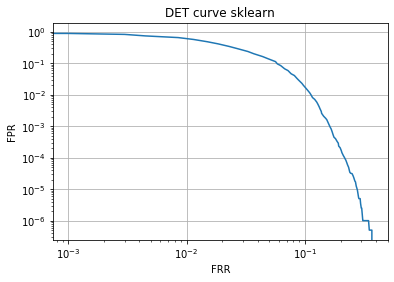

In [14]:
from sklearn.metrics import det_curve
plt.figure()
fpr, frr, th_det = metrics.det_curve(y_true, combined_scores)
plt.plot(frr, fpr)
plt.xlabel('FRR')
plt.ylabel('FPR')
plt.title('DET curve sklearn')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.savefig('./figs/det_sklearn_cum.png')
#print(fpr.shape)

#### 3. F1 and accuracy as metrics

While biometric systems are, traditionally, evaluated using FMR and FRR and ROC/DET curves, we can also have a look at traditional [classification metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) such as classification accuracy (or error) and F1 measure. 

<div class="alert alert-block alert-success">
<b>Q3: </b> Classification Metrics
<ul>
    <li>Plot F1 and accuracy as a function of the decision thresholds on the similarity score.</li>
    <li>Calculate the threshold and accuracy for which F1 is maximal. Is it an interesting operating point?</li>
    <li>Do the same for the classification error (accuracy). Is there a difference?</li>
    <li>Is accuracy a good performance metric in this case?</li>
</ul>  
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> 
We highly recommend you use the <a href="https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics">scikit-learn classification metrics</a> to assist.
</div>


Text(0.5, 1.0, 'Accuracy and F1-score depending on threshold')

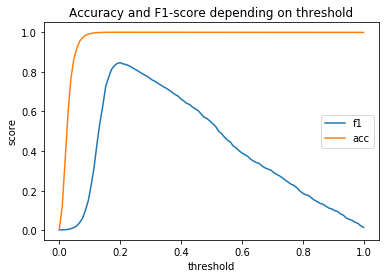

In [15]:
"""Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
# Hint: evaluating for ± 50 threshold values should suffice
plt.figure()
f1_list = []
acc_list = []
new_list = np.flip(th_roc)
for thr in new_list[::3]:           # calculate scores every few thresholds to reduce cost os calculations
    f1 = metrics.f1_score(y_true.astype(bool), combined_scores>thr, pos_label=1)
    acc = metrics.accuracy_score(y_true.astype(bool), combined_scores>thr, normalize=True, sample_weight=None)
    f1_list.append(f1)
    acc_list.append(acc)

xaxis = np.linspace(0,1,len(f1_list))
plt.plot(xaxis,f1_list, label='f1')
plt.plot(xaxis,acc_list, label='acc')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.title('Accuracy and F1-score depending on threshold')
plt.savefig('./figs/acc_f1_cum.png')

In [16]:
"""Calculate the threshold for which F1 is maximal."""
f1_th_max = np.argmax(f1_list)/len(f1_list)             # find where f1 is maximum and get threshold there
print(f1_th_max)

0.19811320754716982


In [17]:
"""Do the same for the classification error (or accuracy)"""
acc_th_max = xaxis[np.argmax(acc_list)]             # find where accuracy is maximum and get the threshold value there
print(acc_th_max)

0.2


#### 4. AUC and EER as summary measures

The overall performance (over all threshold settings) is typically expressed through:

* The Area Under the Curve (AUC) (with TPR((y-axis) vs FPR (x-axis))

<img src="img/AUC.png" width="250" height="auto"/>

The AUC can be used to compare different systems. The larger this number, the better.
However, since it is a summary measure, always inspect the full ROC curve to make decisions about performance given operating conditions (in wich FRR, FAR regime to work e.g.).

* The Equal Error Rate (EER), which is the point on the ROC-curve where FAR(FMR) equals FRR (1-TAR). A lower EER value indicates better performance. 

<img src="img/EER.png" width="300" height="300"/>

<div class="alert alert-block alert-success">
<b>Q4: </b> AUC, EER and alternatives
<ul>
    <li>Calculate ROC AUC. Is this a good metric? What does it reveal about the system? </li>
    <li>Calculate (by approximation) the EER and plot it on the FAR-FRR curve. Is this a good peration point?</li>
    <li>Calculate the decision threshold for which the sum of FRR and FAR is minimal. Is this point similar to the total classification error?</li> 
    <li>Can you suggest other strategies that give you an "optimal" performance? Calculate and discuss their (de)merits.</li>
</ul>  
</div>


In [18]:
"""Calculate the ROC AUC."""
auc = np.abs(np.trapz(tpr_list,fpr_list, dx=1.0, axis=0))       # use np.trapz to calculate area under the curve
print(auc)

0.9743895499999999


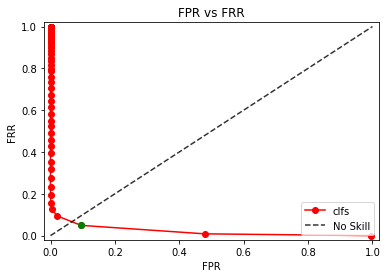

In [19]:
"""Calculate (by approximation) the EER and plot it on the FAR-FRR curve."""
# hints:
#  - avoid using a library that directly computes the EER for this assignment
plt.figure()
plt.plot(fpr_list, np.ones(len(tpr_list)) - tpr_list,'ro-', label="clfs")
plt.xlabel('FPR')
plt.ylabel('FRR')
plt.title('FPR vs FRR')
ax.grid(linestyle='--')

identity_line = np.linspace(0, 1,len(tpr_list))
identity_line2 = np.linspace(1, 0,len(tpr_list))  # this can be used if someone wants to plot the tpr vs fpr (ROC) and EER point there
plt.plot(identity_line,identity_line, linestyle='dashed', color='black', alpha=0.8, label="No Skill")
plt.ylim(-0.02, 1.02)
plt.xlim(-0.02, 1.02)
plt.legend()

eer_pos = np.nanargmin(np.absolute((np.ones(len(tpr_list)) - tpr_list - fpr_list)))     # find index where |FRR - FPR| is min
plt.plot(fpr_list[eer_pos],1-tpr_list[eer_pos],'go')                # since it is on the y=x line, use index for both x and y
plt.savefig('./figs/eer_cum.png')

In [20]:
"""Calculate the decision threshold for which the sum of FRR and FAR is minimal."""
# hint: same as above
thr2 = np.argmin(np.absolute(np.ones(len(fpr_list)) + fpr_list - tpr_list))/len(f1_list)
print(thr2)

0.02830188679245283


#### 5. Evaluation using Precision and Recall

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)
[3]: <https://en.wikipedia.org/w/index.php?title=Information_retrieval&oldid=793358396#Average_precision> (Average precision)

In a general binary classification setting, one also often presents Precision-Recall curves. PR-curves are sometimes summarized using the [average precision scores][3]. How and when to use ROC or PRC is discussed [here][2]. A more general discussion of these measures is provided [here](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c).  

Scikit-Learn provides routines for calculating these curves and numbers as demonstrated in the code below from this [link][2], it also provides an implementation of the [average precision scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score).


<div class="alert alert-block alert-success">
<b>Q5: </b> Precision-Recall curves and related summary measures
<ul>
    <li>Calculate and plot the Precision-Recall curve for this system. What does it reveal about the performance of the system?</li>
    <li>Calculate the Area Under the PR-curve. Discuss.</li>
    <li>Calculate the average precision scores. Discuss its value.</li> 
</ul>  
</div>


Text(0.5, 1.0, 'Precision-Recall Curve')

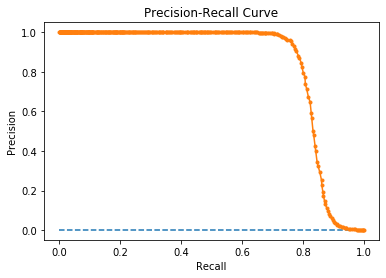

In [21]:
"""Calculate and plot the Precision-Recall curve for this system"""
plt.figure()
precision, recall, thresholds = metrics.precision_recall_curve(y_true, combined_scores)

no_skill = len(y_true[y_true==1]) / len(y_true)         # random classifier
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.savefig('./figs/prec_rec_cum.png')

In [22]:
"""Calculate the Area Under the PR-curve."""
auprc = np.abs(np.trapz(recall,precision, dx=1.0, axis=0))          # use np.trapz to calculate the area
print(auprc)

0.8320305448111682


In [23]:
"""Calculate the average precision scores"""
aps = metrics.average_precision_score(y_true, combined_scores)
print(aps)

0.8310419290571703


## III. Validation of identification system 

### Evaluation using CMC curves
In an identification scenario one has a 1-to-many or multi-class classification problem. The performance of such a system is typically measured by the Cumulative Match Characteristic (CMC) curve. This curve plots the experimental probability that a correct identification is returned within the top-x (x=1, ..., N) ranked matching scores. 

<img src="img/CMC.jpg" width="500" height="auto"/>

[Bolle et al.](https://ieeexplore.ieee.org/document/1544394) show that:
> the CMC is also related to the FAR and FRR of a 1:1 matcher, i.e., the matcher that is used to rank the candidates by sorting the scores. This has as a consequence that when a 1:1 matcher is used for identification, that is, for sorting match scores from high to low, the CMC does not offer any additional information beyond the FAR and FRR curves. The CMC is just another way of displaying the data and can be computed from the FAR and FRR.

This paper is not mandatory but those interested can have a look at it.

CMC curves can easily be generated once you have the ranked matching scores for every test sample. In our example we can easily calculate it from the similarity matrix (note that in this very particular case we have only one genuine pair per test sample). 



<div class="alert alert-block alert-success">
<b>Q6: </b> CMC curves
<ul>
    <li>Calculate the Cumulative Matching Characteristic curve (implement this yourself)</li>
    <li>Compute the Rank-1 Recognition Rate.</li>
</ul>  
</div>


Text(0.5, 1.0, 'Cumulative Match Characteristic (CMC) curve')

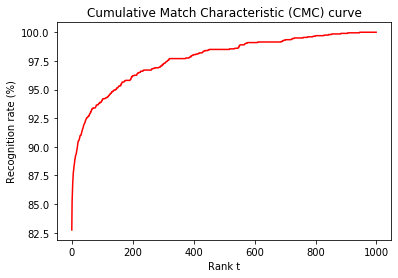

In [24]:
"""Calculate the Cumulative Matching Characteristic curve."""
# Hint: don't use a library
plt.figure()
rank_array = np.zeros(num_subjects)     # eack index corresponds to the rank
# Calculate for left index first
y_new = li_genuine_id.reshape(num_subjects,int(li_genuine_id.shape[0]/num_subjects))
y_new = y_new.transpose()               # change format
scores_new = li_scores.reshape(num_subjects,int(li_scores.shape[0]/num_subjects))       # get li scores
scores_new = scores_new.transpose()     # do the same

for j in range(0,y_new.shape[0]):
    tmp1 = scores_new[j][:]             # get first row
    idx = np.argsort(tmp1)              # find where max similarity is
    idx = idx[::-1]                     # reverse for descending order
    tmp2 = y_new[j][idx]                # sort true labels based on the index returned
    r = np.where(tmp2==1)[0][0]         # calculate the rank = where the 1 exists in the prev list
    rank_array[r] = rank_array[r]+1                 # keep track of the rank in sum array

# NOW for right index and add ranks to the same array
y_new = ri_genuine_id.reshape(num_subjects,int(ri_genuine_id.shape[0]/num_subjects)) 
y_new = y_new.transpose()               # change format
scores_new = ri_scores.reshape(num_subjects,int(ri_scores.shape[0]/num_subjects))       # get ri scores
scores_new = scores_new.transpose()     # do the same

for j in range(0,y_new.shape[0]):
    tmp1 = scores_new[j][:]             # get first row
    idx = np.argsort(tmp1)              # find where max similarity is
    idx = idx[::-1]                     # reverse for descending order
    tmp2 = y_new[j][idx]                # sort true labels based on the index returned
    r = np.where(tmp2==1)[0][0]         # calculate the rank = where the 1 exists in the prev list
    rank_array[r] = rank_array[r]+1                 # keep track of the rank in sum array


R_t = np.cumsum(rank_array)                   # Rank_t ID rate, also known as TPIR
R_t = R_t/R_t.max()*100                 # make it percentage
plt.plot(R_t, 'r')                      # plot it
plt.xlabel('Rank t')
plt.ylabel('Recognition rate (%)')
plt.title('Cumulative Match Characteristic (CMC) curve')
plt.savefig('./figs/cmc_cum.png')

In [26]:
"""compute the Rank-1 Recognition Rate."""
rank_1 = rank_array[0]/rank_array.sum()         # at index 0 are all rank-1 identifiers. Divide by the total sum of the identifiers to get ratio
print(rank_1)

0.8275


<div class="alert alert-block alert-success">
<b>Q7: </b> Evaluate different biometric systems
<ul>
    <li>Use above evaluation techniques to compare the biometric system based on the left index to the right index </li>
    <li>Do you see any differences in any of the curves or measures?</li>
</ul>  
</div>

In [ ]:
# Use main.py in this directory to generate all plots for left and right index. Uses custom class 'Eval_class" from src.eval

## IV. Assignment Instructions
For this assignment you have to submit a report (.pdf) and the implementation of this notebook (.ipynb) to toledo. The report should be between 3-8 pages (more pages $\nRightarrow$ higher score) and should be structured around the posed questions (Q1,...). The text should demonstrate your understanding of the material and, depending on the question, clearly introduce the context, technique, your expectation and interpretation of the results. Do not limit yourselves to just answering the questions. Feel free to add figures and, if needed, some *small* code snippet to clarify your position. **The report should be self contained, the notebook functions as supplementary material only!**

*Note: Make sure you include all the files required to run the notebooks on submission.* <br>
*Note 2: The deadline for this project is: 09/03 23:59 CET.* 